In [35]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_excel("online_retail_II.xlsx",sheet_name="Year 2009-2010")
df_test = pd.read_excel("online_retail_II.xlsx",sheet_name="Year 2010-2011")

In [4]:
print(df_train.isnull().sum())
print(df_test.isnull().sum())

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64
Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64


In [5]:
df_train.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


In [6]:
df_train.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [7]:
df_test.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047.0,United Kingdom


In [8]:
# Data Cleaning
df_train.dropna(subset=['Customer ID'],inplace = True)
df_test.dropna(subset=['Customer ID'],inplace = True)

df_train['InvoiceDate'] = pd.to_datetime(df_train['InvoiceDate'])
df_test['InvoiceDate'] = pd.to_datetime(df_test['InvoiceDate'])

df_train['TotalPrice'] = df_train['Quantity'] * df_train['Price']
df_test['TotalPrice'] = df_test['Quantity'] * df_test['Price']

#last date in the dataset
snapshot_date = df_train['InvoiceDate'].max() + pd.Timedelta(days=1)

In [9]:
df_train['Customer ID'] = df_train['Customer ID'].fillna(0).astype(int)
df_test['Customer ID'] = df_test['Customer ID'].fillna(0).astype(int)

## RFM Segmentation Analysis

In [10]:
# RFM calculation 
# Recency, Frequency, Monetary

rfm = df_train.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, #Recency
    'Invoice': 'nunique', #Frequency
    'TotalPrice': 'sum'}).reset_index()

rfm.columns=['Customer ID','Recency','Frequency','Monetary']

rfm

,Customer ID,Recency,Frequency,Monetary
0,12346,67,15,-64.68
1,12347,3,2,1323.32
2,12348,74,1,222.16
3,12349,43,4,2646.99
4,12351,11,1,300.93
...,...,...,...,...
4378,18283,18,6,641.77
4379,18284,65,2,436.68
4380,18285,296,1,427.00
4381,18286,112,3,1188.43


In [11]:
rfm = rfm[rfm['Monetary'] > 0]

In [12]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# calculate RFM score
rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm['RF_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str)

In [13]:
# Focusing on R and F, segment customers by these 2 scores.

seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-3]': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'[4-5]1': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RF_Score'].replace(seg_map, regex=True)

In [14]:
rfm

,Customer ID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,RF_Score,segment
1,12347,3,2,1323.32,5,2,4,524,52,potential_loyalists
2,12348,74,1,222.16,2,1,1,211,21,hibernating
3,12349,43,4,2646.99,3,3,5,335,33,need_attention
4,12351,11,1,300.93,5,1,2,512,51,new_customers
5,12352,11,2,343.80,5,2,2,522,52,potential_loyalists
...,...,...,...,...,...,...,...,...,...,...
4378,18283,18,6,641.77,4,4,3,443,44,loyal_customers
4379,18284,65,2,436.68,3,3,2,332,33,need_attention
4380,18285,296,1,427.00,1,2,2,122,12,hibernating
4381,18286,112,3,1188.43,2,3,4,234,23,at_Risk


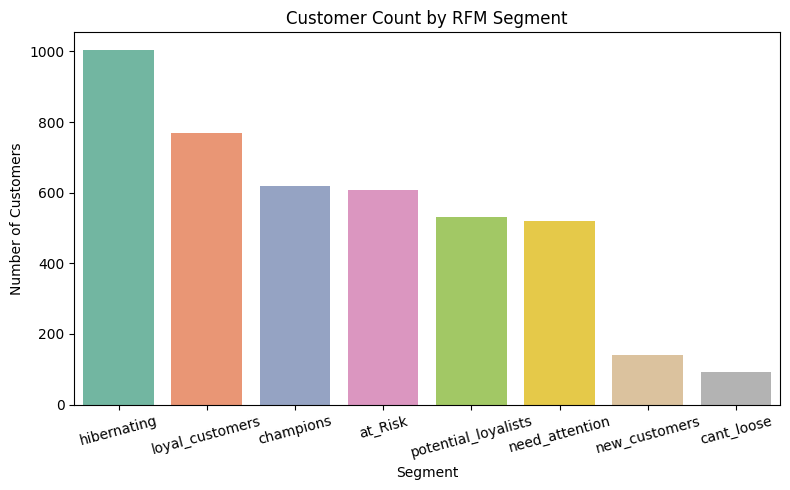

In [15]:
segment_counts = rfm['segment'].value_counts().reset_index()
segment_counts.columns = ['segment', 'Count']

plt.figure(figsize=(8, 5))
sns.barplot(data=segment_counts, x='segment', y='Count', palette='Set2')
plt.title('Customer Count by RFM Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

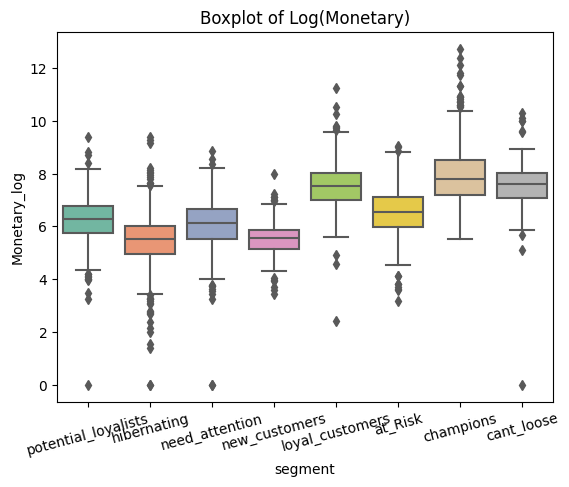

In [16]:
'''
    We applied a logarithmic transformation on the Monetary value to address right skewness and 
    make the segment comparison more interpretable.
'''

rfm['Monetary_log'] = np.log1p(rfm['Monetary']) 

sns.boxplot(data=rfm, x='segment', y='Monetary_log', palette='Set2')
plt.xticks(rotation=15)
plt.title('Boxplot of Log(Monetary)')
plt.show()

## Prediction

In [17]:
clv_label = df_test.groupby('Customer ID')['TotalPrice'].sum().reset_index()
clv_label.columns = ['Customer ID', 'Future_CLV']
clv_label

,Customer ID,Future_CLV
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40
...,...,...
4367,18280,180.60
4368,18281,80.82
4369,18282,176.60
4370,18283,2094.88


In [18]:
#feature engineering

order_dates = df_train.sort_values(['Customer ID','InvoiceDate']).groupby('Customer ID')['InvoiceDate'].apply(list)

def avg_order_interval(dates):
    
    if len(dates) <= 1:
        return np.nan
    
    gaps = np.diff(dates)
    return np.mean([gap.days for gap in gaps])

rfm['avg_order_interval'] = rfm['Customer ID'].map(order_dates.apply(avg_order_interval))

In [19]:
snapshot_date = df_train['InvoiceDate'].max() + pd.Timedelta(days=1)

# customer first & last purchase time
customer_lifespan = df_train.groupby('Customer ID').agg({
    'InvoiceDate': [np.min, np.max]
})
customer_lifespan.columns = ['first_purchase', 'last_purchase']

# active days: snapshot date - first purchase date
customer_lifespan['active_days'] = (snapshot_date - customer_lifespan['first_purchase']).dt.days

rfm = rfm.merge(customer_lifespan[['active_days']], left_on='Customer ID', right_index=True)

In [20]:
cutoff_date = snapshot_date

window_3m = cutoff_date - pd.DateOffset(months=3)

recent_3m = df_train[(df_train['InvoiceDate'] >= window_3m) & (df_train['InvoiceDate'] < cutoff_date)].groupby('Customer ID')['TotalPrice'].agg(['sum', 'count']).reset_index()
recent_3m.columns = ['Customer ID', 'recent_3m_amount', 'recent_3m_orders']

rfm = rfm.merge(recent_3m, on='Customer ID', how='left')

In [21]:
rfm

,Customer ID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,RF_Score,segment,Monetary_log,avg_order_interval,active_days,recent_3m_amount,recent_3m_orders
0,12347,3,2,1323.32,5,2,4,524,52,potential_loyalists,7.188654,0.528571,40,1323.32,71.0
1,12348,74,1,222.16,2,1,1,211,21,hibernating,5.407889,0.000000,74,222.16,20.0
2,12349,43,4,2646.99,3,3,5,335,33,need_attention,7.881556,3.075472,371,1402.62,55.0
3,12351,11,1,300.93,5,1,2,512,51,new_customers,5.710195,0.000000,11,300.93,21.0
4,12352,11,2,343.80,5,2,2,522,52,potential_loyalists,5.842965,0.941176,28,343.80,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4278,18283,18,6,641.77,4,4,3,443,44,loyal_customers,6.465787,1.192140,294,195.35,59.0
4279,18284,65,2,436.68,3,3,2,332,33,need_attention,6.081488,0.071429,67,436.68,29.0
4280,18285,296,1,427.00,1,2,2,122,12,hibernating,6.059123,0.000000,296,NaN,NaN
4281,18286,112,3,1188.43,2,3,4,234,23,at_Risk,7.081229,3.565217,359,NaN,NaN


In [26]:
data = rfm.merge(clv_label, left_on='Customer ID', right_on='Customer ID', how='left')
data['Future_CLV'] = data['Future_CLV'].fillna(0)
data = data[data['Future_CLV'] >= 0]
data['Future_CLV_log'] = np.log1p(data['Future_CLV']) 

### Baseline Model: XGBoost

In [36]:
features = ['Recency', 'Frequency', 'Monetary', 'avg_order_interval', 'active_days','recent_3m_amount','recent_3m_orders']  # 加你已有的特征
X = data[features]
y = data['Future_CLV_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'RMSE: {rmse:.2f}')
print(f"MAE: {mae:.2f}")

RMSE: 2.99
MAE: 2.32


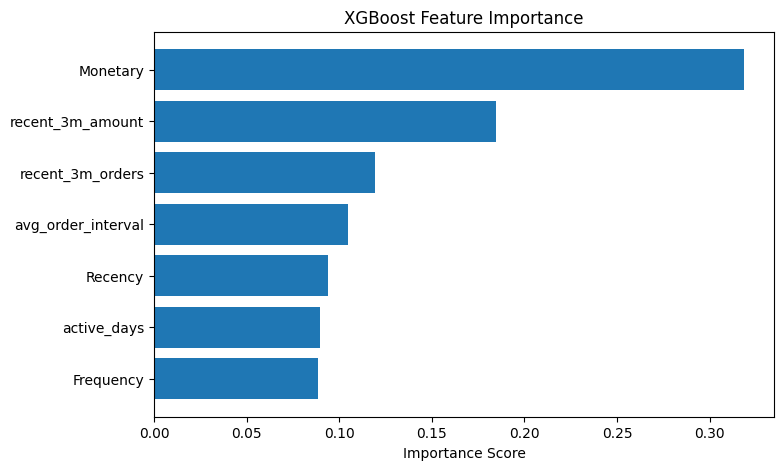

In [34]:
importances = model.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance Score')
plt.show()

In [ ]:
#Hyperparameter tuning

#

In [ ]:
from sklearn.ensemble import StackingRegressor
estimators = [
    ('xgb', XGBRegressor()),
    ('lgb', LGBMRegressor()),
    ('ridge', Ridge())
]
stack_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
